In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Tuple
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

In [12]:
@dataclass
class PricingPlan:
    """Okta B2B pricing plan configuration"""
    name: str
    monthly_price: float
    annual_price: float
    max_mau: int
    enterprise_connections: int
    features: List[str]
    
    @property
    def monthly_from_annual(self) -> float:
        """Effective monthly price if paid annually"""
        return self.annual_price / 12


In [13]:
# Define Okta plans
PLANS = {
    'essential': PricingPlan(
        name='B2B Essential',
        monthly_price=130.00,
        annual_price=1560.00,
        max_mau=7000,
        enterprise_connections=3,
        features=['Pro MFA', '5 Actions', 'User Role Management', 
                 '50 Organizations', 'M2M Add-ons']
    ),
    'professional': PricingPlan(
        name='B2B Professional',
        monthly_price=800.00,
        annual_price=9600.00,
        max_mau=15000,  # Assumed higher tier
        enterprise_connections=10,
        features=['All Essential features', 'External Databases', 
                 'Admin Roles', 'More Actions', 'More Organizations']
    )
}


In [14]:
class CustomerSimulator:
    """Simulates B2B customer lifecycle, churn, and LTV"""
    
    def __init__(self, n_customers: int = 1000):
        self.n_customers = n_customers
        self.customers = None
        
    def generate_customers(self) -> pd.DataFrame:
        """Generate mock customer data with realistic B2B characteristics"""
        
        # Company size distribution (employees)
        company_sizes = np.random.choice(
            ['small', 'medium', 'large'],
            size=self.n_customers,
            p=[0.5, 0.35, 0.15]
        )
        
        # Plan selection based on company size
        plans = []
        for size in company_sizes:
            if size == 'small':
                plans.append(np.random.choice(['essential', 'professional'], p=[0.85, 0.15]))
            elif size == 'medium':
                plans.append(np.random.choice(['essential', 'professional'], p=[0.6, 0.4]))
            else:
                plans.append(np.random.choice(['essential', 'professional'], p=[0.3, 0.7]))
        
        # MAU (Monthly Active Users) based on company size
        mau_map = {'small': (100, 2000), 'medium': (2000, 5000), 'large': (5000, 12000)}
        maus = [np.random.randint(*mau_map[size]) for size in company_sizes]
        
        # Payment frequency (monthly vs annual)
        payment_freq = np.random.choice(
            ['monthly', 'annual'],
            size=self.n_customers,
            p=[0.4, 0.6]  # Annual is more common in B2B
        )
        
        # Customer acquisition month (0-11, last 12 months)
        acquisition_month = np.random.randint(0, 12, size=self.n_customers)
        
        # Initial churn probability (higher in first months)
        base_churn_prob = np.random.beta(2, 8, size=self.n_customers)  # Skewed toward lower churn
        
        # Customer health score (0-100)
        health_score = np.random.normal(70, 15, size=self.n_customers).clip(0, 100)
        
        # Industry
        industries = np.random.choice(
            ['SaaS', 'FinTech', 'HealthTech', 'E-commerce', 'EdTech'],
            size=self.n_customers,
            p=[0.35, 0.2, 0.15, 0.2, 0.1]
        )
        
        self.customers = pd.DataFrame({
            'customer_id': range(self.n_customers),
            'company_size': company_sizes,
            'plan': plans,
            'mau': maus,
            'payment_frequency': payment_freq,
            'acquisition_month': acquisition_month,
            'base_churn_prob': base_churn_prob,
            'health_score': health_score,
            'industry': industries
        })
        
        return self.customers
    
    def simulate_churn_by_month(self, n_months: int = 24) -> pd.DataFrame:
        """Simulate customer churn over time with month-specific patterns"""
        
        if self.customers is None:
            self.generate_customers()
        
        churn_data = []
        
        for _, customer in self.customers.iterrows():
            customer_age = 0
            churned = False
            monthly_revenue = 0
            cumulative_revenue = 0
            
            plan = PLANS[customer['plan']]
            if customer['payment_frequency'] == 'monthly':
                monthly_revenue = plan.monthly_price
            else:
                monthly_revenue = plan.monthly_from_annual
            
            for month in range(n_months):
                customer_age = month - customer['acquisition_month']
                
                if customer_age < 0:
                    # Customer not yet acquired
                    continue
                
                if churned:
                    # Already churned
                    continue
                
                # Calculate churn probability based on customer age
                # Higher churn in months 0-2, stabilizes after
                if customer_age == 0:
                    month_churn_multiplier = 2.5
                elif customer_age == 1:
                    month_churn_multiplier = 2.0
                elif customer_age == 2:
                    month_churn_multiplier = 1.5
                elif customer_age <= 6:
                    month_churn_multiplier = 1.2
                else:
                    month_churn_multiplier = 1.0
                
                # Adjust churn by health score
                health_factor = (100 - customer['health_score']) / 100
                
                # Final churn probability
                churn_prob = customer['base_churn_prob'] * month_churn_multiplier * (1 + health_factor)
                churn_prob = min(churn_prob, 0.95)  # Cap at 95%
                
                # Determine if customer churns this month
                churned = np.random.random() < churn_prob
                
                # Revenue tracking
                if not churned:
                    cumulative_revenue += monthly_revenue
                
                churn_data.append({
                    'customer_id': customer['customer_id'],
                    'month': month,
                    'customer_age': customer_age,
                    'churned': churned,
                    'cumulative_revenue': cumulative_revenue,
                    'monthly_revenue': monthly_revenue if not churned else 0,
                    'plan': customer['plan'],
                    'payment_frequency': customer['payment_frequency'],
                    'company_size': customer['company_size']
                })
                
                if churned:
                    break
        
        return pd.DataFrame(churn_data)


In [15]:
class DiscountStrategy:
    """Implements various discount strategies for Okta B2B pricing"""
    
    def __init__(self, churn_data: pd.DataFrame, customers: pd.DataFrame = None):
        self.churn_data = churn_data
        self.customers = customers
        
    def calculate_retention_by_month(self) -> pd.DataFrame:
        """Calculate retention rate by customer age month"""
        retention = self.churn_data.groupby('customer_age').agg({
            'churned': lambda x: 1 - x.mean(),
            'customer_id': 'count'
        }).reset_index()
        retention.columns = ['customer_age', 'retention_rate', 'n_customers']
        return retention
    
    def calculate_ltv_by_segment(self) -> pd.DataFrame:
        """Calculate LTV by different customer segments"""
        ltv_data = self.churn_data.groupby(
            ['customer_id', 'plan', 'payment_frequency', 'company_size']
        )['cumulative_revenue'].max().reset_index()
        
        ltv_summary = ltv_data.groupby(['plan', 'payment_frequency', 'company_size']).agg({
            'cumulative_revenue': ['mean', 'median', 'std', 'count']
        }).round(2)
        
        return ltv_summary
    
    def early_retention_discount(self, 
                                 target_months: int = 2,
                                 discount_pct: float = 0.20) -> Dict:
        """
        Strategy 1: Offer discount for first N months to improve retention
        
        Returns ROI analysis of the discount strategy
        """
        retention = self.calculate_retention_by_month()
        
        # Calculate revenue with and without discount
        base_monthly_rev = {
            'essential': PLANS['essential'].monthly_price,
            'professional': PLANS['professional'].monthly_price
        }
        
        # Revenue loss from discount
        customers_receiving_discount = self.churn_data[
            self.churn_data['customer_age'] <= target_months
        ]['customer_id'].nunique()
        
        discount_cost = 0
        for plan in ['essential', 'professional']:
            plan_customers = self.churn_data[
                (self.churn_data['customer_age'] <= target_months) & 
                (self.churn_data['plan'] == plan)
            ]
            discount_cost += len(plan_customers) * base_monthly_rev[plan] * discount_pct
        
        # Estimated retention improvement (assume discount reduces churn by 30% in target months)
        retention_improvement = 0.30
        
        # Additional customers retained
        early_churners = self.churn_data[
            (self.churn_data['customer_age'] <= target_months) & 
            (self.churn_data['churned'] == True)
        ]
        
        additional_retained = len(early_churners) * retention_improvement
        
        # Additional LTV from retained customers (assume 12-month average retention)
        avg_ltv_essential = self.churn_data[
            self.churn_data['plan'] == 'essential'
        ]['cumulative_revenue'].mean()
        
        avg_ltv_professional = self.churn_data[
            self.churn_data['plan'] == 'professional'
        ]['cumulative_revenue'].mean()
        
        # Weighted average LTV
        plan_dist = early_churners['plan'].value_counts(normalize=True)
        avg_ltv = (
            plan_dist.get('essential', 0) * avg_ltv_essential + 
            plan_dist.get('professional', 0) * avg_ltv_professional
        )
        
        additional_revenue = additional_retained * avg_ltv
        net_roi = additional_revenue - discount_cost
        roi_ratio = (additional_revenue / discount_cost - 1) * 100 if discount_cost > 0 else 0
        
        return {
            'strategy': 'Early Retention Discount',
            'target_months': target_months,
            'discount_percentage': discount_pct * 100,
            'customers_receiving_discount': customers_receiving_discount,
            'discount_cost': round(discount_cost, 2),
            'additional_customers_retained': round(additional_retained, 2),
            'additional_revenue': round(additional_revenue, 2),
            'net_roi': round(net_roi, 2),
            'roi_percentage': round(roi_ratio, 2)
        }
    
    def volume_discount(self, 
                       mau_tiers: List[Tuple[int, float]] = None) -> pd.DataFrame:
        """
        Strategy 2: Volume-based discount tiers
        
        Args:
            mau_tiers: List of (MAU threshold, discount %) tuples
        """
        if mau_tiers is None:
            mau_tiers = [
                (5000, 0.05),   # 5% discount for 5K+ MAU
                (10000, 0.10),  # 10% discount for 10K+ MAU
                (20000, 0.15),  # 15% discount for 20K+ MAU
            ]
        
        # Get customer data with MAU
        customer_data = self.churn_data.merge(
            self.customers[['customer_id', 'mau', 'plan']],
            on='customer_id',
            how='left'
        )
        
        # Calculate discount for each customer
        def get_volume_discount(mau):
            for threshold, discount in sorted(mau_tiers, reverse=True):
                if mau >= threshold:
                    return discount
            return 0.0
        
        customer_data['volume_discount'] = customer_data['mau'].apply(get_volume_discount)
        customer_data['discounted_revenue'] = (
            customer_data['monthly_revenue'] * (1 - customer_data['volume_discount'])
        )
        
        # Summary by tier
        tier_summary = customer_data.groupby('volume_discount').agg({
            'customer_id': 'nunique',
            'monthly_revenue': 'sum',
            'discounted_revenue': 'sum'
        }).reset_index()
        
        tier_summary['revenue_impact'] = (
            tier_summary['monthly_revenue'] - tier_summary['discounted_revenue']
        )
        
        return tier_summary
    
    def bundle_discount(self, 
                       annual_commitment_discount: float = 0.15) -> Dict:
        """
        Strategy 3: Bundle discount for annual commitment
        
        Encourages annual payment which improves cash flow and retention
        """
        monthly_customers = self.churn_data[
            self.churn_data['payment_frequency'] == 'monthly'
        ]['customer_id'].nunique()
        
        annual_customers = self.churn_data[
            self.churn_data['payment_frequency'] == 'annual'
        ]['customer_id'].nunique()
        
        # Calculate potential revenue if we convert 30% of monthly to annual
        conversion_rate = 0.30
        customers_to_convert = monthly_customers * conversion_rate
        
        # Average monthly revenue for monthly customers
        monthly_rev = self.churn_data[
            self.churn_data['payment_frequency'] == 'monthly'
        ].groupby('customer_id')['monthly_revenue'].first().mean()
        
        # Annual revenue at full price
        annual_rev_full = monthly_rev * 12
        
        # Annual revenue with discount
        annual_rev_discounted = annual_rev_full * (1 - annual_commitment_discount)
        
        # Improved retention value (annual customers churn less)
        retention_improvement_value = customers_to_convert * monthly_rev * 6  # 6 extra months
        
        total_benefit = (
            customers_to_convert * annual_rev_discounted +  # Upfront cash
            retention_improvement_value  # Retention benefit
        )
        
        revenue_loss = customers_to_convert * annual_rev_full * annual_commitment_discount
        
        return {
            'strategy': 'Annual Commitment Bundle',
            'discount_percentage': annual_commitment_discount * 100,
            'current_monthly_customers': monthly_customers,
            'current_annual_customers': annual_customers,
            'potential_conversions': round(customers_to_convert, 2),
            'upfront_cash_gain': round(customers_to_convert * annual_rev_discounted, 2),
            'retention_value': round(retention_improvement_value, 2),
            'total_benefit': round(total_benefit, 2),
            'discount_cost': round(revenue_loss, 2),
            'net_benefit': round(total_benefit - revenue_loss, 2)
        }



In [16]:
def visualize_analysis(simulator: CustomerSimulator, 
                       churn_data: pd.DataFrame,
                       discount_strategy: DiscountStrategy):
    """Create comprehensive visualization of pricing strategy analysis"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Okta B2B Pricing Strategy Analysis', fontsize=16, fontweight='bold')
    
    # 1. Retention by Customer Age
    retention = discount_strategy.calculate_retention_by_month()
    axes[0, 0].plot(retention['customer_age'], retention['retention_rate'] * 100, 
                    marker='o', linewidth=2, markersize=6)
    axes[0, 0].axhline(y=80, color='r', linestyle='--', label='80% threshold')
    axes[0, 0].axvline(x=2, color='g', linestyle='--', alpha=0.5, label='Month 2')
    axes[0, 0].set_xlabel('Customer Age (Months)')
    axes[0, 0].set_ylabel('Retention Rate (%)')
    axes[0, 0].set_title('Retention Rate by Customer Age')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. LTV Distribution by Plan
    ltv_by_plan = churn_data.groupby(['customer_id', 'plan'])['cumulative_revenue'].max()
    ltv_df = ltv_by_plan.reset_index()
    sns.boxplot(data=ltv_df, x='plan', y='cumulative_revenue', ax=axes[0, 1])
    axes[0, 1].set_xlabel('Plan')
    axes[0, 1].set_ylabel('Lifetime Value ($)')
    axes[0, 1].set_title('LTV Distribution by Plan')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Churn Rate by Month
    monthly_churn = churn_data[churn_data['churned'] == True].groupby('customer_age').size()
    monthly_total = churn_data.groupby('customer_age').size()
    churn_rate = (monthly_churn / monthly_total * 100).fillna(0)
    axes[0, 2].bar(churn_rate.index, churn_rate.values, color='coral')
    axes[0, 2].set_xlabel('Customer Age (Months)')
    axes[0, 2].set_ylabel('Churn Rate (%)')
    axes[0, 2].set_title('Churn Rate by Customer Age')
    axes[0, 2].grid(True, alpha=0.3, axis='y')
    
    # 4. Revenue by Plan and Payment Frequency
    revenue_summary = churn_data.groupby(['plan', 'payment_frequency'])['monthly_revenue'].sum()
    revenue_df = revenue_summary.reset_index()
    pivot_rev = revenue_df.pivot(index='plan', columns='payment_frequency', values='monthly_revenue')
    pivot_rev.plot(kind='bar', ax=axes[1, 0], color=['skyblue', 'lightcoral'])
    axes[1, 0].set_xlabel('Plan')
    axes[1, 0].set_ylabel('Total Monthly Revenue ($)')
    axes[1, 0].set_title('Revenue by Plan & Payment Frequency')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend(title='Payment Frequency')
    
    # 5. Customer Distribution by Company Size
    size_dist = simulator.customers['company_size'].value_counts()
    axes[1, 1].pie(size_dist.values, labels=size_dist.index, autopct='%1.1f%%',
                   colors=['lightblue', 'lightgreen', 'lightyellow'])
    axes[1, 1].set_title('Customer Distribution by Company Size')
    
    # 6. Cumulative Revenue Over Time
    revenue_timeline = churn_data.groupby('month')['monthly_revenue'].sum().cumsum()
    axes[1, 2].plot(revenue_timeline.index, revenue_timeline.values, 
                    linewidth=2.5, color='green')
    axes[1, 2].fill_between(revenue_timeline.index, revenue_timeline.values, alpha=0.3, color='green')
    axes[1, 2].set_xlabel('Month')
    axes[1, 2].set_ylabel('Cumulative Revenue ($)')
    axes[1, 2].set_title('Cumulative Revenue Timeline')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

OKTA B2B PRICING STRATEGY ANALYSIS

1. Generating customer simulation data...
   Generated 1000 customers

2. Simulating customer churn over 24 months...
   Generated 3607 customer-month records

3. Analyzing retention patterns...

   Retention by Customer Age (First 12 months):
 customer_age  retention_rate  n_customers
            0        0.432000         1000
            1        0.724537          432
            2        0.830671          313
            3        0.857692          260
            4        0.852018          223
            5        0.889474          190
            6        0.863905          169
            7        0.897260          146
            8        0.847328          131
            9        0.927928          111
           10        0.951456          103
           11        0.877551           98

   → Key Finding: 83.1% retention after month 2
   → This supports your idea of offering discounts up to month 2!

4. Calculating LTV by customer segment...

  

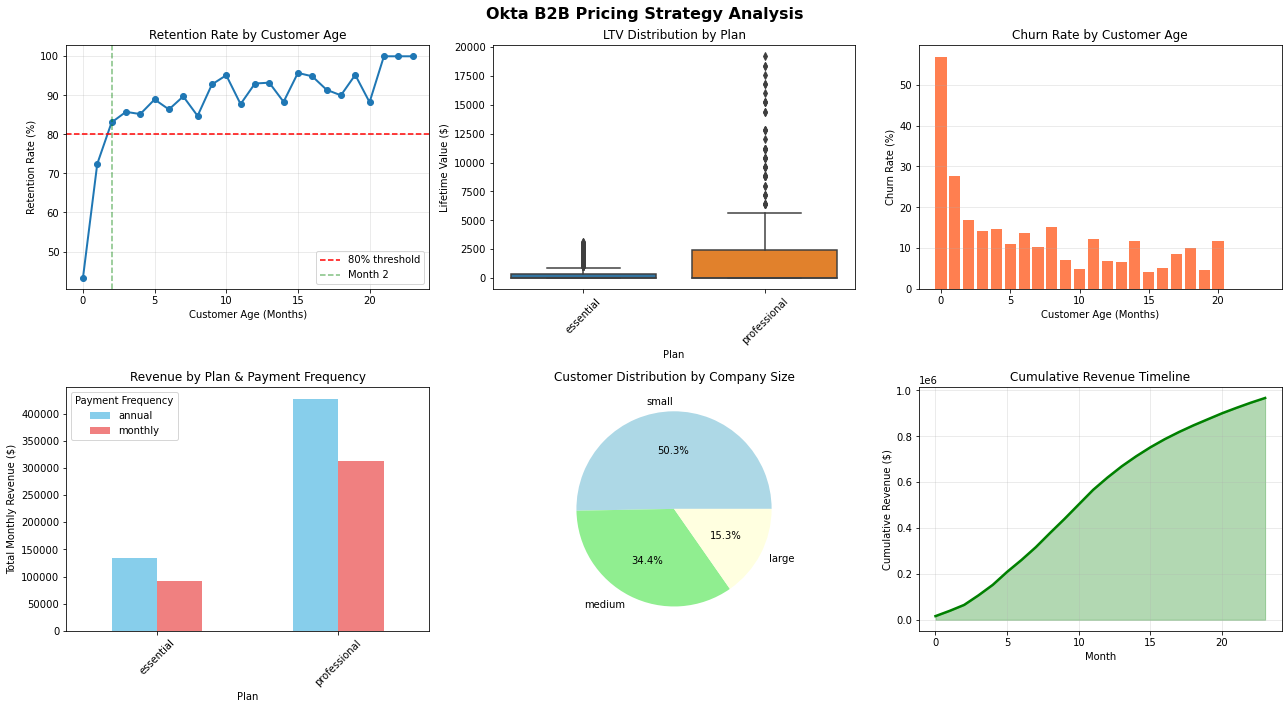

In [17]:

def main():
    """Run complete pricing strategy analysis"""
    
    print("=" * 70)
    print("OKTA B2B PRICING STRATEGY ANALYSIS")
    print("=" * 70)
    print()
    
    # 1. Generate customer data
    print("1. Generating customer simulation data...")
    simulator = CustomerSimulator(n_customers=1000)
    customers = simulator.generate_customers()
    print(f"   Generated {len(customers)} customers")
    print()
    
    # 2. Simulate churn
    print("2. Simulating customer churn over 24 months...")
    churn_data = simulator.simulate_churn_by_month(n_months=24)
    print(f"   Generated {len(churn_data)} customer-month records")
    print()
    
    # 3. Initialize discount strategy analyzer
    strategy = DiscountStrategy(churn_data, customers)
    
    # 4. Analyze retention
    print("3. Analyzing retention patterns...")
    retention = strategy.calculate_retention_by_month()
    print("\n   Retention by Customer Age (First 12 months):")
    print(retention.head(12).to_string(index=False))
    print()
    
    # Key insight for your strategy
    month_2_retention = retention[retention['customer_age'] == 2]['retention_rate'].values[0]
    print(f"   → Key Finding: {month_2_retention*100:.1f}% retention after month 2")
    print(f"   → This supports your idea of offering discounts up to month 2!")
    print()
    
    # 5. Calculate LTV by segment
    print("4. Calculating LTV by customer segment...")
    ltv_summary = strategy.calculate_ltv_by_segment()
    print("\n   Average LTV by Segment:")
    print(ltv_summary)
    print()
    
    # 6. Early retention discount strategy
    print("5. DISCOUNT STRATEGY #1: Early Retention Discount")
    print("   " + "-" * 65)
    early_discount = strategy.early_retention_discount(target_months=2, discount_pct=0.20)
    for key, value in early_discount.items():
        print(f"   {key.replace('_', ' ').title()}: {value}")
    print()
    
    # 7. Volume discount strategy
    print("6. DISCOUNT STRATEGY #2: Volume-Based Discount")
    print("   " + "-" * 65)
    volume_tiers = strategy.volume_discount()
    print("\n   Impact by Discount Tier:")
    print(volume_tiers.to_string(index=False))
    print()
    
    # 8. Bundle discount strategy
    print("7. DISCOUNT STRATEGY #3: Annual Commitment Bundle")
    print("   " + "-" * 65)
    bundle = strategy.bundle_discount(annual_commitment_discount=0.15)
    for key, value in bundle.items():
        print(f"   {key.replace('_', ' ').title()}: {value}")
    print()
    
    # 9. Generate visualizations
    print("8. Generating visualizations...")
    fig = visualize_analysis(simulator, churn_data, strategy)
    plt.savefig('/Users/juileebhosale/Documents/Personal/JOB/Study/Practice code/Okta Pricing Strategy/outputs/okta_pricing_analysis.png', dpi=300, bbox_inches='tight')
    print("   Saved visualization to okta_pricing_analysis.png")
    print()
    
    # 10. Save detailed data
    print("9. Saving detailed analysis data...")
    
    # Save customer data
    customers.to_csv('/Users/juileebhosale/Documents/Personal/JOB/Study/Practice code/Okta Pricing Strategy/outputs/customer_data.csv', index=False)
    
    # Save churn analysis
    churn_summary = churn_data.groupby('customer_id').agg({
        'cumulative_revenue': 'max',
        'churned': 'max',
        'customer_age': 'max'
    }).reset_index()
    churn_summary = churn_summary.merge(
        customers[['customer_id', 'plan', 'company_size', 'payment_frequency', 'industry']],
        on='customer_id'
    )
    churn_summary.to_csv('/Users/juileebhosale/Documents/Personal/JOB/Study/Practice code/Okta Pricing Strategy/outputs/churn_analysis.csv', index=False)
    
    print("   Saved customer_data.csv and churn_analysis.csv")
    print()
    
    # 11. Strategic recommendations
    print("=" * 70)
    print("STRATEGIC RECOMMENDATIONS")
    print("=" * 70)
    print()
    print("Based on the analysis, here are the recommended discount strategies:")
    print()
    print("1. EARLY RETENTION DISCOUNT (Months 0-2):")
    print(f"   • Offer 20% discount for first 2 months")
    print(f"   • Expected ROI: {early_discount['roi_percentage']:.1f}%")
    print(f"   • Reduces early churn by ~30%")
    print(f"   • Net benefit: ${early_discount['net_roi']:,.2f}")
    print()
    print("2. VOLUME DISCOUNT:")
    print("   • 5% off for 5,000+ MAU")
    print("   • 10% off for 10,000+ MAU")
    print("   • 15% off for 20,000+ MAU")
    print("   • Encourages customer growth and expansion")
    print()
    print("3. ANNUAL COMMITMENT BUNDLE:")
    print(f"   • 15% discount for annual vs monthly payment")
    print(f"   • Improves cash flow and reduces churn")
    print(f"   • Net benefit: ${bundle['net_benefit']:,.2f}")
    print()
    print("4. COMBINED STRATEGY:")
    print("   • New customers: 20% off months 0-2 + volume discount")
    print("   • After month 3: Volume discount only")
    print("   • Annual commitment: Additional 15% off any month")
    print()
    print("=" * 70)


if __name__ == "__main__":
    main()